## Introduction to the general linear model

This workbook was adapted from Matthew Brett's GitHub which can be found [here](https://matthew-brett.github.io/teaching/glm_intro.html)

In [4]:
# import numerical and plotting libraries
import numpy as np
import numpy.linalg as npl
import matplotlib.pyplot as plt
%matplotlib inline

# Only show 6 decimals when printing
np.set_printoptions(precision = 6)

Here is a list of psychopathy scores. We want to do a regression to test whether these scores correlate with skin-conductance scores (claminess)

In [6]:
psychopathy = [11.416,   4.514,  12.204,  14.835,
...                8.416,   6.563,  17.343, 13.02,
...                15.19 ,  11.902,  22.721,  22.324]

In [7]:
clammy = [0.389,  0.2  ,  0.241,  0.463,
...           4.585,  1.097,  1.642,  4.972,
...           7.957,  5.585,  5.527,  6.964]

In [19]:
age = [22.5,  25.3,  24.6,  21.4,
...        20.7,  23.3,  23.8,  21.7,
...        21.3, 25.2,  24.6,  21.8]

Let's plot these two variables together and take a look at the data

Text(0.5, 1.0, 'Relationship between claminess and psychopathy')

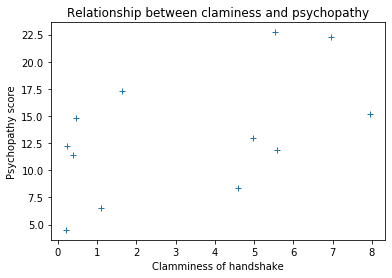

In [11]:
plt.plot(clammy, psychopathy, '+')
plt.xlabel('Clamminess of handshake')
plt.ylabel('Psychopathy score')
plt.title('Relationship between claminess and psychopathy')

In [17]:
def my_line(x):
    # My prediction for psychopathy given clamminess
    return 10 + 0.9 * x

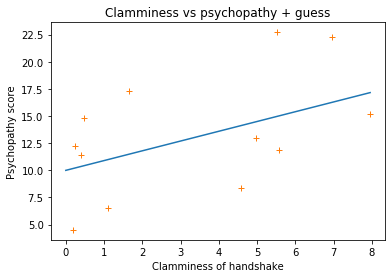

In [18]:
# Now we can plot our prediction
x_vals = [0, max(clammy)]
y_vals = [my_line(0), my_line(max(clammy))]
plt.plot(x_vals, y_vals)
plt.xlabel('Clamminess of handshake')
plt.ylabel('Psychopathy score')
plt.title('Clamminess vs psychopathy + guess')
plt.plot(clammy, psychopathy, '+')

We can understand this better if we consider our psychopathy data a vector with 12 values, oen for each student. y1 is the first etc. Our clammy data is our predictor. This can be another vector with 12 values.

Our straight line model says:

𝑦𝑖 ≈ 𝑐 + 𝑏𝑥𝑖

where c is the intercept, b is the slope. For our guessed line above, we had:

yi ≈ 10 + 0.9Xi

This can be rephrased to state that each observation is equal to the predicted value plus some error from each observation.

Let's actually estimate our line properly, using the squared distance between the predicted values and the actual values.

In [20]:
X = np.column_stack((np.ones(12), clammy))
X

array([[1.   , 0.389],
       [1.   , 0.2  ],
       [1.   , 0.241],
       [1.   , 0.463],
       [1.   , 4.585],
       [1.   , 1.097],
       [1.   , 1.642],
       [1.   , 4.972],
       [1.   , 7.957],
       [1.   , 5.585],
       [1.   , 5.527],
       [1.   , 6.964]])

In [21]:
# We can now use the psudoinverse to get estimated B
B = npl.pinv(X).dot(psychopathy)
B

array([10.071286,  0.999257])

In [24]:
def my_best_line(x):
    # Best prediction for psychopathy given clamminess
    return B[0] + B[1] * x

Text(0, 0.5, 'Psychopathy score')

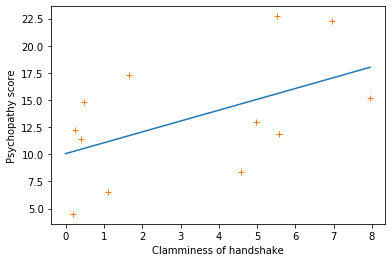

In [26]:
# Plot our new prediction
x_vals = [0, max(clammy)]
y_vals = [my_best_line(0), my_best_line(max(clammy))]
plt.plot(x_vals, y_vals)
plt.plot(clammy, psychopathy, '+')
plt.xlabel('Clamminess of handshake')
plt.ylabel('Psychopathy score')

In [28]:
fitted = X.dot(B)
errors = psychopathy - fitted
print(np.sum(errors ** 2))

252.9256064499382


In [30]:
# Is this smaller than our original guess of an 
# intercept of 10 and a slope of 0.9? HINT, YES!

fitted = X.dot([10, 0.9])
errors = psychopathy - fitted
print(np.sum(errors ** 2))

255.75076072


Now we need to consider contrasts. If clamminess does predict psychopathy, then we would expect the slope of the best fit line between clammy and psychopathy to be different from zero. So then we could make two lines where the slope of one is 0 and the slope of the second is 1.

To test whether the estimate is different from zero, we can divide the esitmate by the variability of the estimate. This gives us an idea of how far the estimate is from zero, in terms of the variability of the estimate.

With that, we can now do hte estimate and find a t-statistic.

In [31]:
# We can get a t-distribution code from the scipy library
from scipy.stats import t as t_dist

In [33]:
def t_stat(y, X, c):
    """ betas, t statistic and significance test given data, design matrix, contrast
...
...     This is OLS estimation; we assume the errors to have independent
...     and identical normal distributions around zero for each $i$ in
...     $\e_i$ (i.i.d).
...     """
    # Make sure y, X, c are all arrays
    y = np.asarray(y)
    X = np.asarray(X)
    c = np.atleast_2d(c).T # As column vector
    # Calculate the parameters - b hat
    beta = npl.pinv(X).dot(y)
    # The fitted values - y hat
    fitted = X.dot(beta)
    # Residual error
    errors = y - fitted
    # Residual sum of errors
    RSS = (errors**2).sum(axis=0)
    # Degrees of freedom is the number of observations n minus the number
    # of independent regressors we have used.  If all the regressor
    # columns in X are independent then the (matrix rank of X) == p
    # (where p the number of columns in X). If there is one column that
    # can be expressed as a linear sum of the other columns then
    # (matrix rank of X) will be p - 1 - and so on.
    df = X.shape[0] - npl.matrix_rank(X)
    # Mean residual sum of squares
    MRSS = RSS / df
    # calculate bottom half of t statistic
    SE = np.sqrt(MRSS * c.T.dot(npl.pinv(X.T.dot(X)).dot(c)))     
    t = c.T.dot(beta) / SE
    # Get p value for t value using cumulative density dunction
    # (CDF) of t distribution
    ltp = t_dist.cdf(t, df) # lower tail p
    p = 1 - ltp # upper tail p
    return beta, t, df, p

So does clammyness predict psychopathy? If it doesnt, then our estimate of the slope will not be significantly different from 0. The t test divides our estimate of the slope by the error in the estimate; large calues mean that the slope is large compared to the error in the estimate.

In [34]:
X = np.column_stack((np.ones(12), clammy))
Y = np.asarray(psychopathy)
B, t, df, p = t_stat(Y, X, [0, 1])
t, p

(array([[1.914389]]), array([[0.042295]]))

In [35]:
berkeley_indicator = [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
stanford_indicator = [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0]
mit_indicator      = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]

In [36]:
X = np.column_stack((berkeley_indicator, 
                    stanford_indicator,
                    mit_indicator))
X

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

In [37]:
B  = npl.pinv(X).dot(psychopathy)
B

array([10.74225, 11.3355 , 18.03425])

In [39]:
np.mean(psychopathy[:4])

10.74225

In [40]:
np.mean(psychopathy[4:8])

11.3355

In [41]:
np.mean(psychopathy[8:])

18.03425

Looks like MIT students are psycho. Let's test this using a contrast

In [42]:
B, t, df, p = t_stat(psychopathy, X, [-0.5, -0.5, 1])
t, p

(array([[2.340356]]), array([[0.021997]]))

### ANCOVA in the general linear model

In [44]:
X = np.column_stack((berkeley_indicator,
                    stanford_indicator,
                    mit_indicator,
                    clammy))
X

array([[1.   , 0.   , 0.   , 0.389],
       [1.   , 0.   , 0.   , 0.2  ],
       [1.   , 0.   , 0.   , 0.241],
       [1.   , 0.   , 0.   , 0.463],
       [0.   , 1.   , 0.   , 4.585],
       [0.   , 1.   , 0.   , 1.097],
       [0.   , 1.   , 0.   , 1.642],
       [0.   , 1.   , 0.   , 4.972],
       [0.   , 0.   , 1.   , 7.957],
       [0.   , 0.   , 1.   , 5.585],
       [0.   , 0.   , 1.   , 5.527],
       [0.   , 0.   , 1.   , 6.964]])

We then test the independent effect of the clamminess score with a contrast on the clammy slope parameter:

In [45]:
B, t, df, p = t_stat(psychopathy, X, [0, 0, 0, 1])
t, p

(array([[-0.010661]]), array([[0.504122]]))

This shows that there is not much independent effect of clamminess. While the MIT students have clammy hands, once we know the student is from MIT, the clammy score is not as useful.